In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom


In [2]:
os.getcwd()

'/Users/mohamedfadhil/image Classification of animals'

In [4]:
import os
from PIL import Image

dataset_path = "flowers/"

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):  # Only process directories
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(file_path)  # Try opening the image
                img.verify()  # Verify if the image is valid
            except (IOError, SyntaxError):
                print(f"Corrupted or unsupported file: {file_path}")


In [5]:


dataset_path = "flowers/"

for root, _, files in os.walk(dataset_path):
    for file in files:
        if not (file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif"))):
            file_path = os.path.join(root, file)
            os.remove(file_path)
            print(f"Removed non-image file: {file_path}")


In [6]:
# image directory
DATA_DIR = os.listdir("flowers/")
DATA_DIR

['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']

In [8]:
# fetch image 
count = 0
for dir in DATA_DIR:
    files = list(os.listdir("flowers/"+dir))
    print(dir)
    print(len(files))
    count += len(files)
print("total no of images in the data set = " + str(count))

daisy
764
rose
784
tulip
984
dandelion
1052
sunflower
733
total no of images in the data set = 4317


### load images 

In [9]:
import os

dataset_path = "flowers/"
invalid_files = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if not file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            invalid_files.append(os.path.join(root, file))

print(f"Invalid files: {invalid_files}")


Invalid files: []


In [10]:
# used variables throughout
base_dir = "flowers/"
img_size = 180
batch = 32 

In [42]:
train_dataset = tf.keras.utils.image_dataset_from_directory(base_dir,
                                                            seed = 123,
                                                            validation_split = 0.2,
                                                            subset = 'training',
                                                            batch_size= batch,
                                                            image_size =(img_size,img_size))

test_dataset = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                            seed = 123,
                                                            validation_split = 0.2,
                                                            subset = 'validation',
                                                            batch_size= batch,
                                                            image_size =(img_size,img_size))

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [43]:
flowers_names = train_dataset.class_names
flowers_names


['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

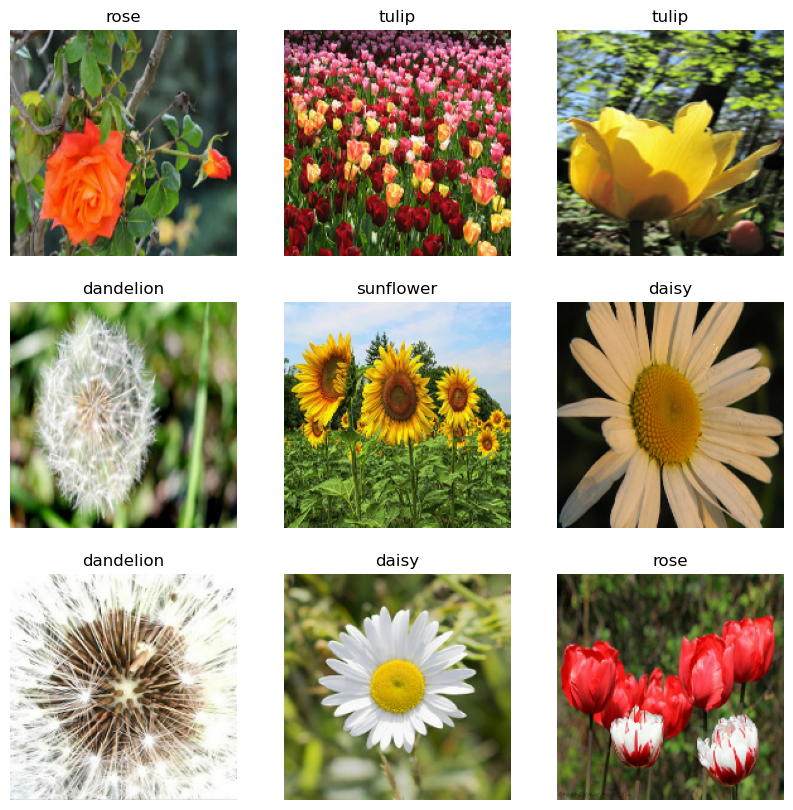

In [44]:
#visual a few images
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(flowers_names[labels[i]])
        plt.axis('off')


In [45]:
# to add to cash memory
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(100).prefetch(buffer_size = AUTOTUNE)

test_dataset = test_dataset.cache().prefetch(buffer_size = AUTOTUNE)

# Data Augmentation

In [46]:
data_augmentation = Sequential([
    Input(shape=(img_size, img_size, 3)),
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

2024-12-10 17:04:10.040957: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-10 17:04:10.342495: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


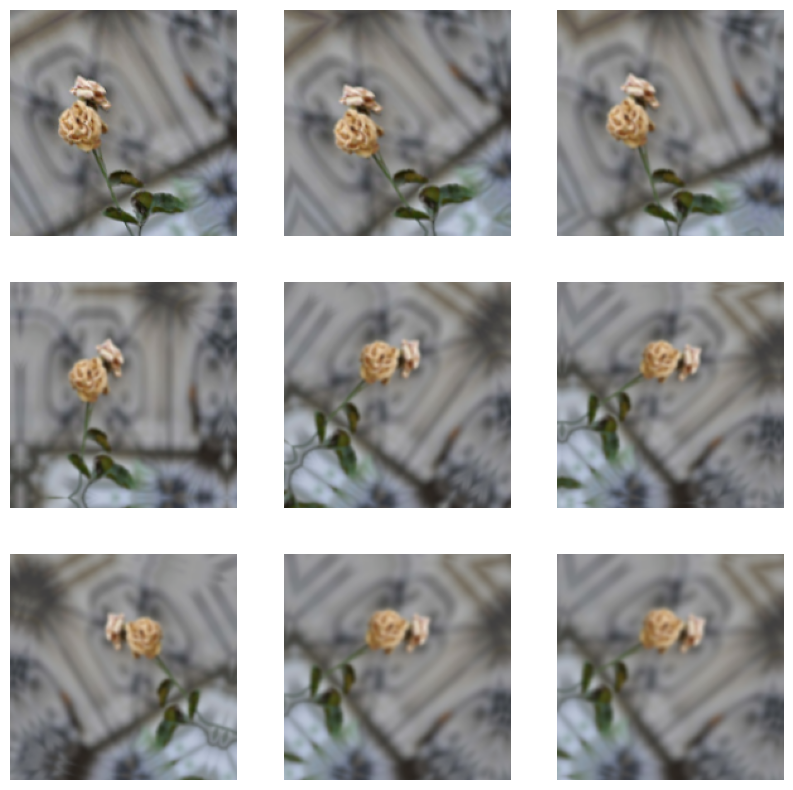

In [47]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_dataset.take(1):
    for i in range (9):
        images = data_augmentation(images)
        plt.subplot(3,3,i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [48]:
# Model Creation

In [49]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(filters =16, kernel_size=3 ,padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32,3,padding='same', activation = "relu"),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128,activation = 'relu'),
    Dense(5)
])

In [50]:
model.compile(optimizer = 'adam',
             loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics =['accuracy'])

In [51]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 64800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     8,294,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,300,261 (31.66 MB)

 Trainable params: 8,300,261 (31.66 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
#fit the model
history = model.fit(train_dataset,epochs = 15,validation_data = test_dataset)

Epoch 1/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 214ms/step - accuracy: 0.3183 - loss: 2.0591 - val_accuracy: 0.5539 - val_loss: 1.0555
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.5804 - loss: 1.0534 - val_accuracy: 0.5643 - val_loss: 1.0963
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 186ms/step - accuracy: 0.6273 - loss: 0.9640 - val_accuracy: 0.6083 - val_loss: 0.9874
Epoch 4/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 192ms/step - accuracy: 0.6694 - loss: 0.8892 - val_accuracy: 0.6419 - val_loss: 0.9477
Epoch 5/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - accuracy: 0.6834 - loss: 0.8466 - val_accuracy: 0.6686 - val_loss: 0.8663
Epoch 6/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 185ms/step - accuracy: 0.6765 - loss: 0.8341 - val_accuracy: 0.6767 - val_loss: 0.8494
Epoch 7/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.7116 - loss: 0.7583 - val_accuracy: 0.6929 - val_loss: 0.8213
Epoch 8/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 201ms/step - accuracy: 0.7076 - loss: 0

In [53]:
# pridict the sample of this model
def classify_image(image_pth):
    input_image = tf.keras.utils.load_img(image_pth, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    prediction = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(prediction[0])

    outcome = f" this is predicted as a {flowers_names[np.argmax(result)]} with accuracy : {max(result)} "
    print(outcome)
    
    return



In [58]:
# test with new images
classify_image("samples/daisy.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 this is predicted as a daisy with accuracy : 0.8252068161964417 


In [59]:
classify_image("samples/sunflower.jpeg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 this is predicted as a sunflower with accuracy : 0.9968621730804443 


In [61]:
classify_image("samples/rose.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
 this is predicted as a rose with accuracy : 0.9032366275787354 


In [62]:
# save the model 
model.save('flower_classification_model.keras')